Download (wget), unzip (unzip) and move the PID data to HDFS.


In [ ]:
$ hdfs dfs -mkdir -p hive_02/pid_gtfs\
$ hdfs dfs -put PID_GTFS/* hive_02/pid_gtfs
$ hdfs dfs -ls hive_02/pid_gtfs

Found 16 items

-rw-r--r--   2 debian users        162 2022-10-25 09:00 hive_02/pid_gtfs/agency.txt

-rw-r--r--   2 debian users      18706 2022-10-25 09:00 hive_02/pid_gtfs/calendar.txt

-rw-r--r--   2 debian users     124035 2022-10-25 09:00 hive_02/pid_gtfs/calendar_dates.txt

## 1.


Check all present databases. Create your own AND use already created via `USE` command.

If your want to be sure, that you are always using crrect DB, you must provide full path, such as `SELECT * FROM jnovak.route LIMIT 10;`

In [ ]:
SHOW DATABASES;
CREATE DATABASE <your_user_name_db>;
USE your_user_name_db;

Create a folder for external tables, you will create.

In [ ]:
$ hdfs dfs -mkdir -p hive_02/ext_tables/routes
$ hdfs dfs -cp hive_02/pid_gtfs/routes.txt hive_02/ext_tables/routes

Create an external table for routes.txt

In [ ]:
create external table route_ext
(
route_id string,
agency_id string,
route_short_name string,
route_long_name string,
route_type string,
route_url string,
route_color string,
route_text_color string,
is_night boolean,
is_regional boolean,
is_substitute_transport boolean
)
row format delimited
fields terminated by ','
lines terminated by '\n'
stored as textfile
location '/user/debian/hive_02/ext_tables/routes/'
tblproperties ("skip.header.line.count" = "1");


Checkout the data and do some basic queries.

In [ ]:
select * from route_ext limit 10;

select count(*) from route_ext;

select count(*) from route_ext where route_short_name is NULL;


## 2.

Create Hive Managed table with final datatypes and other properties.

In [ ]:
create table route
(
route_id string,
agency_id string,
route_short_name string,
route_long_name string,
route_type string,
route_url string,
route_color string,
route_text_color string,
is_night boolean,
is_regional boolean,
is_substitute_transport boolean
)
stored as parquet
tblproperties("parquet.compress"="SNAPPY");

Fill in the final route table.

In [ ]:
insert overwrite table route 
select
route_id, agency_id, route_short_name, route_long_name, route_type,
route_url, route_color, route_text_color, is_night, is_regional, is_substitute_transport
from route_ext;


Do some simple queries.

Is the NULL count same for external and internal table?

In [ ]:
select * from route limit 10;

select count(*) from route;

select count(*) from route where route_short_name is NULL; 

In [ ]:
hdfs dfs -du -s -h /user/hive/warehouse/debian.db  --result 74.4 K

describe formatted route; --shows in bytes (76139)

-- exteranl table size is 82.9K

## 3.1 a 3.2.

Create and exteerna table `stop_times_ext`

In [ ]:
create external table stop_times_ext
    (
    trip_id string,
    arrival_time string,
    departure_time string,
    stop_id string,
    stop_sequence string,
    stop_headsign string,
    pickup_type string,
    drop_off_type string,
    shape_dist_traveled string,
    trip_operation_type string,
    bikes_allowed string
    )
    row format delimited
    fields terminated by ','
    lines terminated by '\n'
    stored as textfile
    location '/user/debian/hive_02/ext_tables/stop_times/'
    tblproperties ("skip.header.line.count"="1");

Create a different order of columns than in original CSV file, because hive takes the last column as partition

It is not possible to select as table to an external table and partitioned table.
Unfortunatelly, there is an issue with Parque and partitioning with current old version of Hive on metacentrum Hadoop, so use Hive ORC while creating tables.
There is also an options `set hive.default.fileformat=orc`


*   *What is default hive format?* 
*   *What are pros/cons of this format?*
*   *What are pros/cons of other formats?*






In [ ]:
CREATE TABLE IF NOT EXISTS stop_times_ext_correct
STORED AS ORC
AS SELECT 
    arrival_time ,
    departure_time ,
    stop_id ,
    stop_sequence ,
    stop_headsign ,
    pickup_type ,
    drop_off_type ,
    shape_dist_traveled ,
    trip_operation_type ,
    bikes_allowed ,
    trip_id 
 from stop_times_ext;

Create the final table with correct datatypes and partition as a last column as well

In [ ]:
create table stop_times
    (
    arrival_time string,
    departure_time string,
    stop_id string,
    stop_sequence string,
    stop_headsign string,
    pickup_type string,
    drop_off_type string,
    shape_dist_traveled string,
    trip_operation_type string,
    bikes_allowed boolean
    )
    partitioned by (trip_id string)
    STORED AS ORC;

Verify tables via `DESCRIBE` command.

In [ ]:
DESCRIBE stop_times;


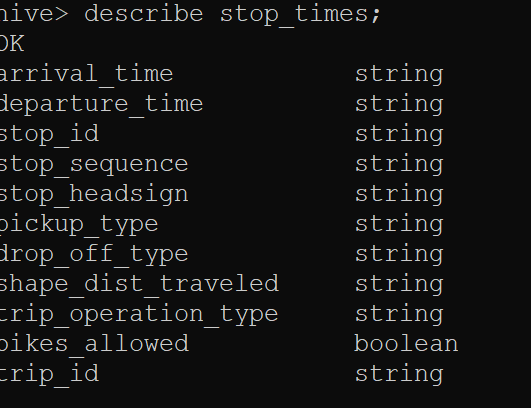

Fill in the data from the correctly ordered table.

In [ ]:
set hive.exec.dynamic.partition=true;
set hive.exec.dynamic.partition.mode=nonstrict;


In [ ]:
insert overwrite table stop_times partition (trip_id)
select
arrival_time, departure_time, stop_id, stop_sequence,
stop_headsign, pickup_type, drop_off_type, shape_dist_traveled, trip_operation_type, bikes_allowed,
substr(trip_id,1,1) as trip_id
from stop_times_ext_correct;


## 4. Inquiry over Hive
Work with the *route* and *stop_times_part* table.

4.1 Find out how many unique routes are there. *(810)*
select count(1) from route;

4.2 Find out the lowest and highest route number are there. *(1, 996)*
 
select min(route_id), max(route_id) from route  ;

4.3 Find out the longest and the shortest route. *(730,1723)*
select max(cast (shape_dist_traveled as int)) route,substr(trip_id, 1,instr(trip_id, '_')-1) from stop_times_part group by substr(trip_id, 1,instr(trip_id, '_')-1) order by route desc limit 1;

4.4 Find out the route with most and least stops. *(908,1803)*
select max(cast (stop_sequence as int)) as stop, substr(trip_id, 1,instr(trip_id, '_')-1) from stop_times_part group by substr(trip_id, 1,instr(trip_id, '_')-1) order by stop desc limit 1;

4.5 Find out the longest regional and night route. *(tbd)*

4.6 Find out two stops with maximum and minimum distance between. *(U9443Z4 U897Z63, U32044Z1  U32043Z1 ) *
 select stop_id, lag (stop_id) over (partition by trip_id order by cast (stop_sequence as int)), (cast(shape_dist_traveled as float)-cast( lag (shape_dist_traveled) over (partition by trip_id order by cast (stop_sequence as int)) as float)) as dist, trip_id,stop_sequence  from stop_times_part order by dist desc limit 10;
4.7 Find out the average speed for route L1, L170 and L991.  *(tbd)*